In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
from datetime import datetime
from tqdm import tqdm

In [62]:
def get_energy_data():

    # get all available time stamps
    stampsurl = "https://www.smard.de/app/chart_data/410/DE/index_quarterhour.json"
    response = requests.get(stampsurl)

    # ignore first 4 years (don't need those in the baseline and speeds the code up a bit)
    # timestamps = list(response.json()["timestamps"])[4*52:]

    # ignore first 8 years (historic data is in already saved csv)
    timestamps = list(response.json()["timestamps"])[8*52 + 45:]

    col_names = ['date_time', 'Netzlast_Gesamt']
    energydata = pd.DataFrame(columns=col_names)
    
    # loop over all available timestamps
    for stamp in tqdm(timestamps):

        dataurl = "https://www.smard.de/app/chart_data/410/DE/410_DE_quarterhour_" + str(stamp) + ".json"
        response = requests.get(dataurl)
        rawdata = response.json()["series"]

        for i in range(len(rawdata)):
            rawdata[i][0] = datetime.fromtimestamp(int(str(rawdata[i][0])[:10])).strftime("%Y-%m-%d %H:%M:%S")

        if energydata.empty:
            energydata = pd.DataFrame(rawdata, columns=col_names)
        else: 
            energydata = pd.concat([energydata, pd.DataFrame(rawdata, columns=col_names)])

    energydata = energydata.dropna()
    energydata["date_time"] = pd.to_datetime(energydata.date_time)
    # set date_time as index
    energydata.set_index("date_time", inplace=True)
    # resample
    # energydata = energydata.resample("1h", label="left").sum()

    return energydata

In [63]:
df = get_energy_data()
display(df.head())
display(df.tail())

100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


,Netzlast_Gesamt
date_time,
2023-10-30 00:00:00,10971.75
2023-10-30 00:15:00,10798.75
2023-10-30 00:30:00,10732.50
2023-10-30 00:45:00,10690.00
2023-10-30 01:00:00,10609.75


,Netzlast_Gesamt
date_time,
2024-01-17 21:45:00,15255.00
2024-01-17 22:00:00,15139.25
2024-01-17 22:15:00,14880.00
2024-01-17 22:30:00,14632.00
2024-01-17 22:45:00,14404.00


Rename column for convenience

In [7]:
df = df.rename(columns={"Netzlast_Gesamt": "gesamt"})

Rescale Netzlast so it fits requirements

In [8]:
df['gesamt'] = df['gesamt'] / 1000

Check dtypes and if columns contain and missing values

In [9]:
df.dtypes

gesamt    float64
dtype: object

In [10]:
df.isna().any()

gesamt    False
dtype: bool

Define weekday column

In [11]:
df["weekday"] = df.index.weekday #Monday=0, Sunday=6
# df["time"] = df.index.strftime("%H:%M")

Lead times are

In [12]:
horizons_def = [36, 40, 44, 60, 64, 68] # [24 + 12*i for i in range(5)]
horizons_def

[36, 40, 44, 60, 64, 68]

Adapt horzions so they actually fit

In [26]:
horizons = [h+2 for h in horizons_def]
horizons

[38, 42, 46, 62, 66, 70]

In [27]:
def get_date_from_horizon(last_ts, horizon):
    return last_ts + pd.DateOffset(hours=horizon)

In [65]:
LAST_IDX = -1
LAST_DATE = df.iloc[LAST_IDX].name

print(LAST_DATE)

2024-01-17 22:45:00


Get time and date that correspond to the lead times (starting at the last observation in our data which should be the respective thursday 0:00)  
*Attention*: if the last timestamp in the data is not thursday 0:00, you have to adjust your lead times accordingly

In [29]:
horizon_date = [get_date_from_horizon(LAST_DATE, h) for h in horizons]
horizon_date

[Timestamp('2024-01-19 12:00:00'),
 Timestamp('2024-01-19 16:00:00'),
 Timestamp('2024-01-19 20:00:00'),
 Timestamp('2024-01-20 12:00:00'),
 Timestamp('2024-01-20 16:00:00'),
 Timestamp('2024-01-20 20:00:00')]

quantile levels

In [30]:
tau = [.025, .25, .5, .75, .975]

In [31]:
# rows correspond to horizon, columns to quantile level
pred_baseline = np.zeros((6,5))

In [39]:
last_t = 100

for i,d in enumerate(horizon_date):
    
    weekday = d.weekday()
    hour = d.hour
    
    df_tmp = df.iloc[:LAST_IDX]
    
    cond = (df_tmp.weekday == weekday) & (df_tmp.index.time == d.time())
    
    pred_baseline[i,:] = np.quantile(df_tmp[cond].iloc[-last_t:]["gesamt"], q=tau, method='median_unbiased')

In [40]:
pred_baseline

array([[53.12173333, 60.32454167, 63.3315    , 66.6098125 , 72.63195208],
       [48.97817292, 55.72366667, 58.491375  , 62.38220833, 68.14030417],
       [49.32181042, 52.41879167, 55.982125  , 58.927     , 65.41275833],
       [47.58415417, 51.01814583, 53.70675   , 56.42645833, 62.65591875],
       [43.93267917, 46.96666667, 49.828125  , 53.3534375 , 59.28986875],
       [43.24113958, 46.4881875 , 48.92575   , 52.85972917, 57.71395208]])

Visually check if quantiles make sense

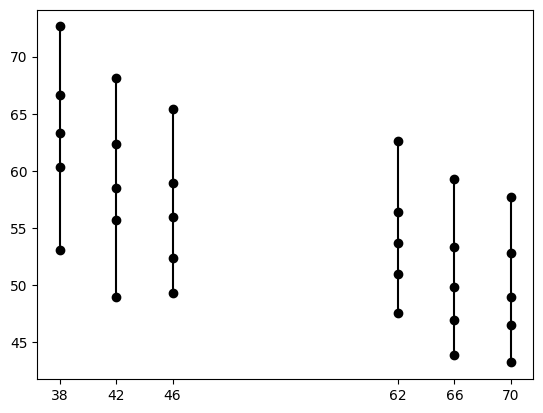

In [41]:
x = horizons
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

In [35]:
from datetime import datetime, date, timedelta
date_str = datetime.today().strftime('%Y%m%d')

In [36]:
date_str = date.today() #- timedelta(days=1)
date_str = date_str.strftime('%Y%m%d')
date_str

'20240117'

In [37]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "energy",
    "horizon": [str(h) + " hour" for h in horizons_def],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,20240117,energy,36 hour,53.274763,60.327375,63.331500,66.604062,71.828094
1,20240117,energy,40 hour,50.642019,55.750000,58.491375,62.370375,67.863419
2,20240117,energy,44 hour,49.348806,52.423625,55.982125,58.662000,65.096013
3,20240117,energy,60 hour,47.755431,51.050062,53.706750,56.397625,61.975600
4,20240117,energy,64 hour,44.081156,47.022000,49.828125,53.217188,58.907137
5,20240117,energy,68 hour,43.284444,46.577937,48.925750,52.850313,57.511206


In [38]:
#need to change this
PATH = "/save/to/path"


df_sub.to_csv(PATH+date_str+"_power_benchmark.csv", index=False)

OSError: Cannot save file into a non-existent directory: '\save\to'